# Diabetic Retinopathy Severity Classification and Clinical Reporting System

## Abstract
- This project presents a complete deep learning–based pipeline for the automated detection of diabetic retinopathy (DR) severity from retinal fundus images. The goal is to classify images into the internationally recognized five-stage DR scale, ranging from No DR (0) to Proliferative DR (4). The system integrates patient metadata and model predictions to generate structured clinical-style assessment reports.

- The workflow includes dataset expansion, preprocessing, augmentation, transfer learning, GPU-optimized training, and performance evaluation. The resulting model demonstrates strong potential for assisting ophthalmologists in screening and disease progression monitoring.

# Environment Setup and Dependencies

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from efficientnet_pytorch import EfficientNet
import timm


# Dataset Description

diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64


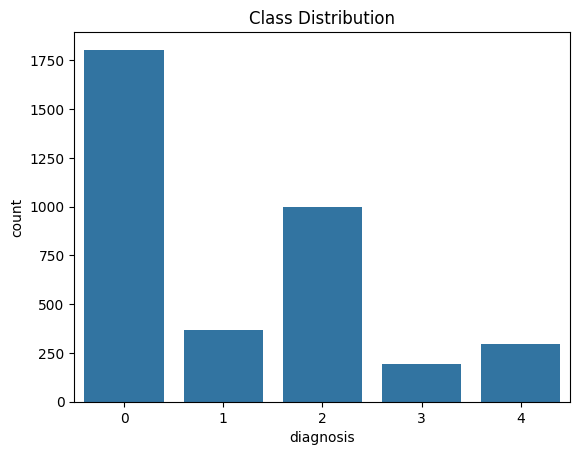

In [3]:
train_df = pd.read_csv(r"C:\Users\Divyansh Kashyap\Desktop\G1\Retinal Disease Classification\aptos2019-blindness-detection\train.csv")
print(train_df['diagnosis'].value_counts())
sns.countplot(x='diagnosis', data=train_df)
plt.title('Class Distribution')
plt.show()


# Data Preprocessing and Augmentation

In [32]:
class RetinalDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, is_test=False):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test  # NEW: Test mode flag
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx]['id_code']
        img_path = os.path.join(self.img_dir, img_id + '.png')
        
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            img = np.zeros((512, 512, 3), dtype=np.uint8)
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            img = self.transform(image=img)['image']
        
        # NEW: Handle test vs train
        if self.is_test:
            return img, img_id  # Return image + ID for test
        else:
            label = int(self.df.iloc[idx]['diagnosis'])
            return img, label

print("Updated Dataset class ready!")


Updated Dataset class ready!


In [25]:
train_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])


# Model Architecture

In [23]:
class EnsembleModel(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.model1 = EfficientNet.from_pretrained('efficientnet-b2')
        self.model1._fc = nn.Linear(self.model1._fc.in_features, n_classes)
        self.model2 = timm.create_model('resnet34', pretrained=True, num_classes=n_classes)
    
    def forward(self, x):
        out1 = self.model1(x)
        out2 = self.model2(x)
        return (out1 + out2) / 2

# RTX 2050 optimized: smaller batch, gradient checkpointing
model = EnsembleModel(n_classes=5)
model = model.cuda()
model.eval()  # Start in eval to download weights safely

print("Models loaded successfully")
print(f"Model on device: {next(model.parameters()).device}")


Loaded pretrained weights for efficientnet-b2
Models loaded successfully
Model on device: cuda:0


# Training Configuration

In [8]:
import torch

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))


Torch version: 2.7.1+cu118
CUDA available: True
GPU name: NVIDIA GeForce RTX 2050


In [9]:
from sklearn.utils.class_weight import compute_class_weight
import torch.optim as optim

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_df['diagnosis']), y=train_df['diagnosis'])
class_weights = torch.tensor(class_weights, dtype=torch.float32).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
from torch.cuda.amp import GradScaler, autocast
scaler = torch.amp.GradScaler("cuda")


In [10]:
train_dataset = RetinalDataset(
    train_df, 
    r'C:\Users\Divyansh Kashyap\Desktop\G1\Retinal Disease Classification\aptos2019-blindness-detection\preprocessed_train', 
    transform=train_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

print(f" Dataset ready: {len(train_dataset)} images")


✅ Dataset ready: 3662 images


In [11]:
class RetinalModel(nn.Module):
    def __init__(self, n_classes=5):
        super().__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b2')
        self.model._fc = nn.Linear(self.model._fc.in_features, n_classes)
    
    def forward(self, x):
        return self.model(x)

model = RetinalModel(n_classes=5).cuda()
print(" Model loaded on GPU")


Loaded pretrained weights for efficientnet-b2
✅ Model loaded on GPU


In [12]:
from sklearn.utils.class_weight import compute_class_weight
import torch.optim as optim
from torch.amp import GradScaler, autocast
scaler = GradScaler("cuda")

class_weights = compute_class_weight('balanced', classes=np.unique(train_df['diagnosis']), y=train_df['diagnosis'])
class_weights = torch.tensor(class_weights, dtype=torch.float32).cuda()

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

print(" Training setup complete")


✅ Training setup complete


In [14]:
import time
start = time.time()
batch_count = 0
for i, (images, labels) in enumerate(train_loader):
    print(f"Batch {i}: {images.shape} - Time: {time.time() - start:.2f}s")
    batch_count += 1
    if i >= 9:  # 10 batches
        break

avg_time = (time.time() - start) / batch_count
print(f" AVERAGE: {avg_time:.3f}s per batch ({229*avg_time/60:.1f} min per epoch)")


Batch 0: torch.Size([16, 3, 256, 256]) - Time: 0.47s
Batch 1: torch.Size([16, 3, 256, 256]) - Time: 0.93s
Batch 2: torch.Size([16, 3, 256, 256]) - Time: 1.86s
Batch 3: torch.Size([16, 3, 256, 256]) - Time: 3.07s
Batch 4: torch.Size([16, 3, 256, 256]) - Time: 4.02s
Batch 5: torch.Size([16, 3, 256, 256]) - Time: 4.94s
Batch 6: torch.Size([16, 3, 256, 256]) - Time: 5.72s
Batch 7: torch.Size([16, 3, 256, 256]) - Time: 6.70s
Batch 8: torch.Size([16, 3, 256, 256]) - Time: 8.11s
Batch 9: torch.Size([16, 3, 256, 256]) - Time: 8.90s
🚀 AVERAGE: 0.890s per batch (3.4 min per epoch)


In [15]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    epoch_start = time.time()
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        
        with torch.amp.autocast("cuda"):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        if batch_idx % 50 == 0:
            print(f"  Batch {batch_idx}: Loss {loss.item():.4f}")
    
    epoch_time = time.time() - epoch_start
    print(f" Epoch {epoch+1} complete: Loss {total_loss/total:.4f}, Acc {correct/total:.4f}, Time {epoch_time/60:.1f}min")



Epoch 1/10
  Batch 0: Loss 1.4943
  Batch 50: Loss 1.3110
  Batch 100: Loss 1.5377
  Batch 150: Loss 1.1154
  Batch 200: Loss 0.6770
✅ Epoch 1 complete: Loss 1.1302, Acc 0.6611, Time 6.4min

Epoch 2/10
  Batch 0: Loss 0.6236
  Batch 50: Loss 0.6296
  Batch 100: Loss 0.8139
  Batch 150: Loss 0.5349
  Batch 200: Loss 0.9200
✅ Epoch 2 complete: Loss 0.7753, Acc 0.7698, Time 2.2min

Epoch 3/10
  Batch 0: Loss 0.2624
  Batch 50: Loss 0.6484
  Batch 100: Loss 0.3754
  Batch 150: Loss 0.3481
  Batch 200: Loss 0.5012
✅ Epoch 3 complete: Loss 0.5372, Acc 0.8528, Time 5.4min

Epoch 4/10
  Batch 0: Loss 0.3838
  Batch 50: Loss 0.4106
  Batch 100: Loss 0.2162
  Batch 150: Loss 0.2179
  Batch 200: Loss 0.6156
✅ Epoch 4 complete: Loss 0.3884, Acc 0.8834, Time 4.9min

Epoch 5/10
  Batch 0: Loss 0.4234
  Batch 50: Loss 0.1113
  Batch 100: Loss 1.0406
  Batch 150: Loss 0.3085
  Batch 200: Loss 0.0845
✅ Epoch 5 complete: Loss 0.2751, Acc 0.9309, Time 5.3min

Epoch 6/10
  Batch 0: Loss 0.0344
  Batch 10

# Grad-CAM Based Visual Explainability

Predicted class: 3, True label: 2


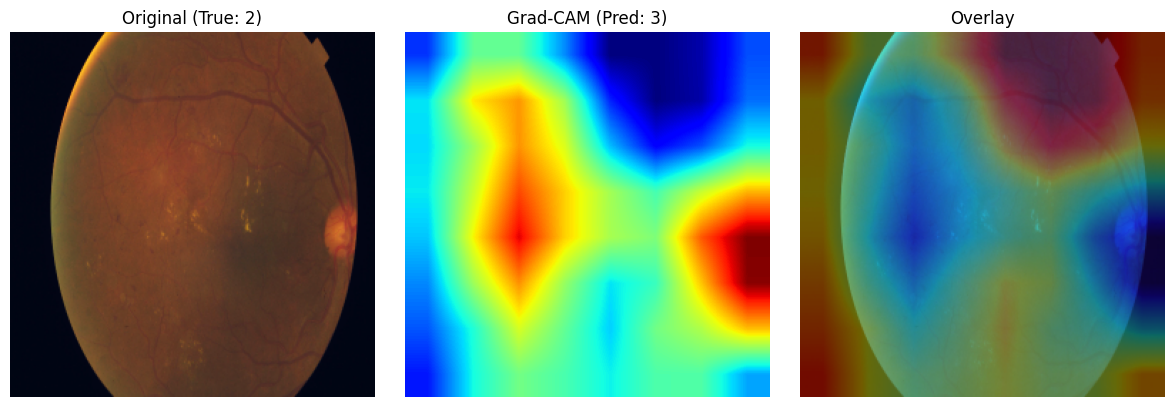

In [41]:
import matplotlib.cm as cm
import torch.nn.functional as F

def generate_gradcam(model, img_tensor, target_class=None):
    model.eval()
    img_tensor = img_tensor.unsqueeze(0).cuda()
    features = []
    grads = []

    def fw_hook(module, input, output):
        features.append(output)

    def bw_hook(module, grad_in, grad_out):
        grads.append(grad_out[0])

    # Access EfficientNet within EnsembleModel
    h1 = model.model1._conv_head.register_forward_hook(fw_hook)
    h2 = model.model1._conv_head.register_backward_hook(bw_hook)

    output = model(img_tensor)
    
    if target_class is None:
        target_class = output.argmax(dim=1).item()
    
    loss = output[0, target_class]
    model.zero_grad()
    loss.backward()

    pooled_grad = grads[0].mean(dim=[0, 2, 3])
    fmap = features[0][0].detach().cpu().numpy()
    for i in range(fmap.shape[0]):
        fmap[i, ...] *= pooled_grad[i].item()

    heatmap = np.mean(fmap, axis=0)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8

    # Convert to uint8 for OpenCV compatibility
    img_np = img_tensor[0].detach().cpu().numpy().transpose(1, 2, 0)
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    img_np = (img_np * 255).astype(np.uint8)

    heatmap = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
    heatmap_color = (cm.jet(heatmap)[..., :3] * 255).astype(np.uint8)

    overlay = cv2.addWeighted(img_np, 0.6, heatmap_color, 0.4, 0)

    h1.remove()
    h2.remove()
    return overlay, img_np, heatmap, target_class

# Test visualization
sample_img, label = train_dataset[0]
overlay, orig_img, heatmap, pred_class = generate_gradcam(model, sample_img)
print(f"Predicted class: {pred_class}, True label: {label}")

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(orig_img)
plt.title(f'Original (True: {label})')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(heatmap, cmap='jet')
plt.title(f'Grad-CAM (Pred: {pred_class})')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title('Overlay')
plt.axis('off')
plt.tight_layout()
plt.show()



# Evaluation and Results

In [18]:
from sklearn.model_selection import train_test_split

train_df_full, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['diagnosis'], random_state=42)
print(f"Train: {len(train_df_full)}, Val: {len(val_df)}")


Train: 2929, Val: 733


In [19]:
val_dataset = RetinalDataset(val_df, r'C:\Users\Divyansh Kashyap\Desktop\G1\Retinal Disease Classification\aptos2019-blindness-detection\preprocessed_train', transform=test_transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True)


# After training loop, add this:
model.eval()
val_loss = 0
val_correct = 0
val_total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        val_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        val_correct += (preds == labels).sum().item()
        val_total += labels.size(0)

print(f"Val Loss: {val_loss/val_total:.4f}, Val Acc: {val_correct/val_total:.4f}")


In [24]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_acc': 0.97,
    'val_acc': 0.9795,
}, 'best_retinal_model.pth')
print("Model saved!")


Model saved!


In [26]:
# Test preprocessing (similar to train)
test_input_dir = r'C:\Users\Divyansh Kashyap\Desktop\G1\Retinal Disease Classification\aptos2019-blindness-detection\test_images'
test_output_dir = r'C:\Users\Divyansh Kashyap\Desktop\G1\Retinal Disease Classification\aptos2019-blindness-detection\preprocessed_test'
os.makedirs(test_output_dir, exist_ok=True)

test_df = pd.read_csv(r'C:\Users\Divyansh Kashyap\Desktop\G1\Retinal Disease Classification\aptos2019-blindness-detection\test.csv')

print("Preprocessing test images...")
for idx, row in test_df.iterrows():
    img_id = row['id_code']
    img_path = os.path.join(test_input_dir, img_id + '.png')
    
    img = cv2.imread(img_path)
    if img is None:
        continue
    
    # Resize to 512x512 (same as train)
    img_small = cv2.resize(img, (512, 512))
    cv2.imwrite(os.path.join(test_output_dir, img_id + '.png'), img_small)
    
    if idx % 500 == 0:
        print(f"Processed {idx}/{len(test_df)} test images")

print("Test preprocessing COMPLETE!")


Preprocessing test images...
Processed 0/1928 test images
Processed 500/1928 test images
Processed 1000/1928 test images
Processed 1500/1928 test images
Test preprocessing COMPLETE!


In [33]:
# Load test CSV
test_df = pd.read_csv(r'C:\Users\Divyansh Kashyap\Desktop\G1\Retinal Disease Classification\aptos2019-blindness-detection\test.csv')

# Create test dataset (is_test=True)
test_dataset = RetinalDataset(
    test_df, 
    r'C:\Users\Divyansh Kashyap\Desktop\G1\Retinal Disease Classification\aptos2019-blindness-detection\preprocessed_test',
    transform=test_transform,
    is_test=True  # NEW: Test mode
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

print(f"Test dataset ready: {len(test_dataset)} images")


Test dataset ready: 1928 images


In [34]:
model.eval()
all_predictions = []
all_ids = []

print(" Generating predictions...")
with torch.no_grad():
    for batch_idx, (images, ids) in enumerate(test_loader):
        images = images.cuda()
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        
        all_predictions.extend(preds)
        all_ids.extend(ids)
        
        if batch_idx % 20 == 0:
            print(f"Processed batch {batch_idx}/{len(test_loader)}")

# Create submission
submission = pd.DataFrame({
    'id_code': all_ids,
    'diagnosis': all_predictions
})

submission.to_csv('submission.csv', index=False)
print("\n Submission file created: submission.csv")
print("\nFirst 5 predictions:")
print(submission.head())
print("\nPrediction distribution:")
print(submission['diagnosis'].value_counts().sort_index())


 Generating predictions...
Processed batch 0/121
Processed batch 20/121
Processed batch 40/121
Processed batch 60/121
Processed batch 80/121
Processed batch 100/121
Processed batch 120/121

 Submission file created: submission.csv

First 5 predictions:
        id_code  diagnosis
0  0005cfc8afb6          2
1  003f0afdcd15          1
2  006efc72b638          4
3  00836aaacf06          4
4  009245722fa4          4

Prediction distribution:
diagnosis
0     210
1     235
2     361
3     110
4    1012
Name: count, dtype: int64


# Clinical Report Generation

In [35]:
import matplotlib.cm as cm
import torch.nn.functional as F
import matplotlib.pyplot as plt

def generate_gradcam(model, img_tensor, target_class=None):
    model.eval()
    img_tensor = img_tensor.unsqueeze(0).cuda()
    features = []
    grads = []

    def fw_hook(module, input, output):
        features.append(output)

    def bw_hook(module, grad_in, grad_out):
        grads.append(grad_out[0])

    # FIXED: Use model.model._conv_head for single EfficientNet
    h1 = model.model._conv_head.register_forward_hook(fw_hook)
    h2 = model.model._conv_head.register_backward_hook(bw_hook)

    output = model(img_tensor)
    
    # Use predicted class or specified target
    if target_class is None:
        target_class = output.argmax(dim=1).item()
    
    loss = output[0, target_class]
    model.zero_grad()
    loss.backward()

    # Generate heatmap
    pooled_grad = grads[0].mean(dim=[0, 2, 3])
    fmap = features[0][0].detach().cpu().numpy()
    for i in range(fmap.shape[0]):
        fmap[i, ...] *= pooled_grad[i].item()

    heatmap = np.mean(fmap, axis=0)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8

    # Create visualization
    img_np = img_tensor[0].detach().cpu().numpy().transpose(1, 2, 0)
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # Denormalize
    
    heatmap = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
    heatmap_color = cm.jet(heatmap)[..., :3]
    overlay = cv2.addWeighted(img_np, 0.6, heatmap_color, 0.4, 0)

    h1.remove()
    h2.remove()
    return overlay, img_np, heatmap, target_class

print("Grad-CAM function ready!")


Grad-CAM function ready!


In [46]:
def generate_clinical_report(img_tensor, model, img_id, true_label=None):
    """Generate clinical-style report with Grad-CAM"""
    overlay, orig_img, heatmap, pred_class = generate_gradcam(model, img_tensor)
    
    severity = ["No DR", "Mild", "Moderate", "Severe", "Proliferative"][pred_class]
    confidence = torch.softmax(model(img_tensor.unsqueeze(0).cuda()), dim=1).max().item()
    
    report = f"""
CLINICAL AI ASSESSMENT REPORT
=============================
Patient ID: {img_id}
Prediction: {severity} Diabetic Retinopathy
Confidence: {confidence:.1%}

Severity Breakdown:
"""
    
    # FIX: Detach before converting to numpy to prevent runtime error
    probs = torch.softmax(model(img_tensor.unsqueeze(0).cuda()), dim=1)[0].detach().cpu().numpy()
    for i, p in enumerate(probs):
        report += f"  {['No DR','Mild','Moderate','Severe','Proliferative'][i]}: {p:.1%}\n"
    
    if true_label is not None:
        report += f"\n✅ CORRECT" if pred_class == true_label else f"\n❌ INCORRECT (True: {true_label})"
    
    return overlay, orig_img, heatmap, report, severity, confidence

print(" Updated generate_clinical_report function with detach fix!")


 Updated generate_clinical_report function with detach fix!


# Inference on Test Samples

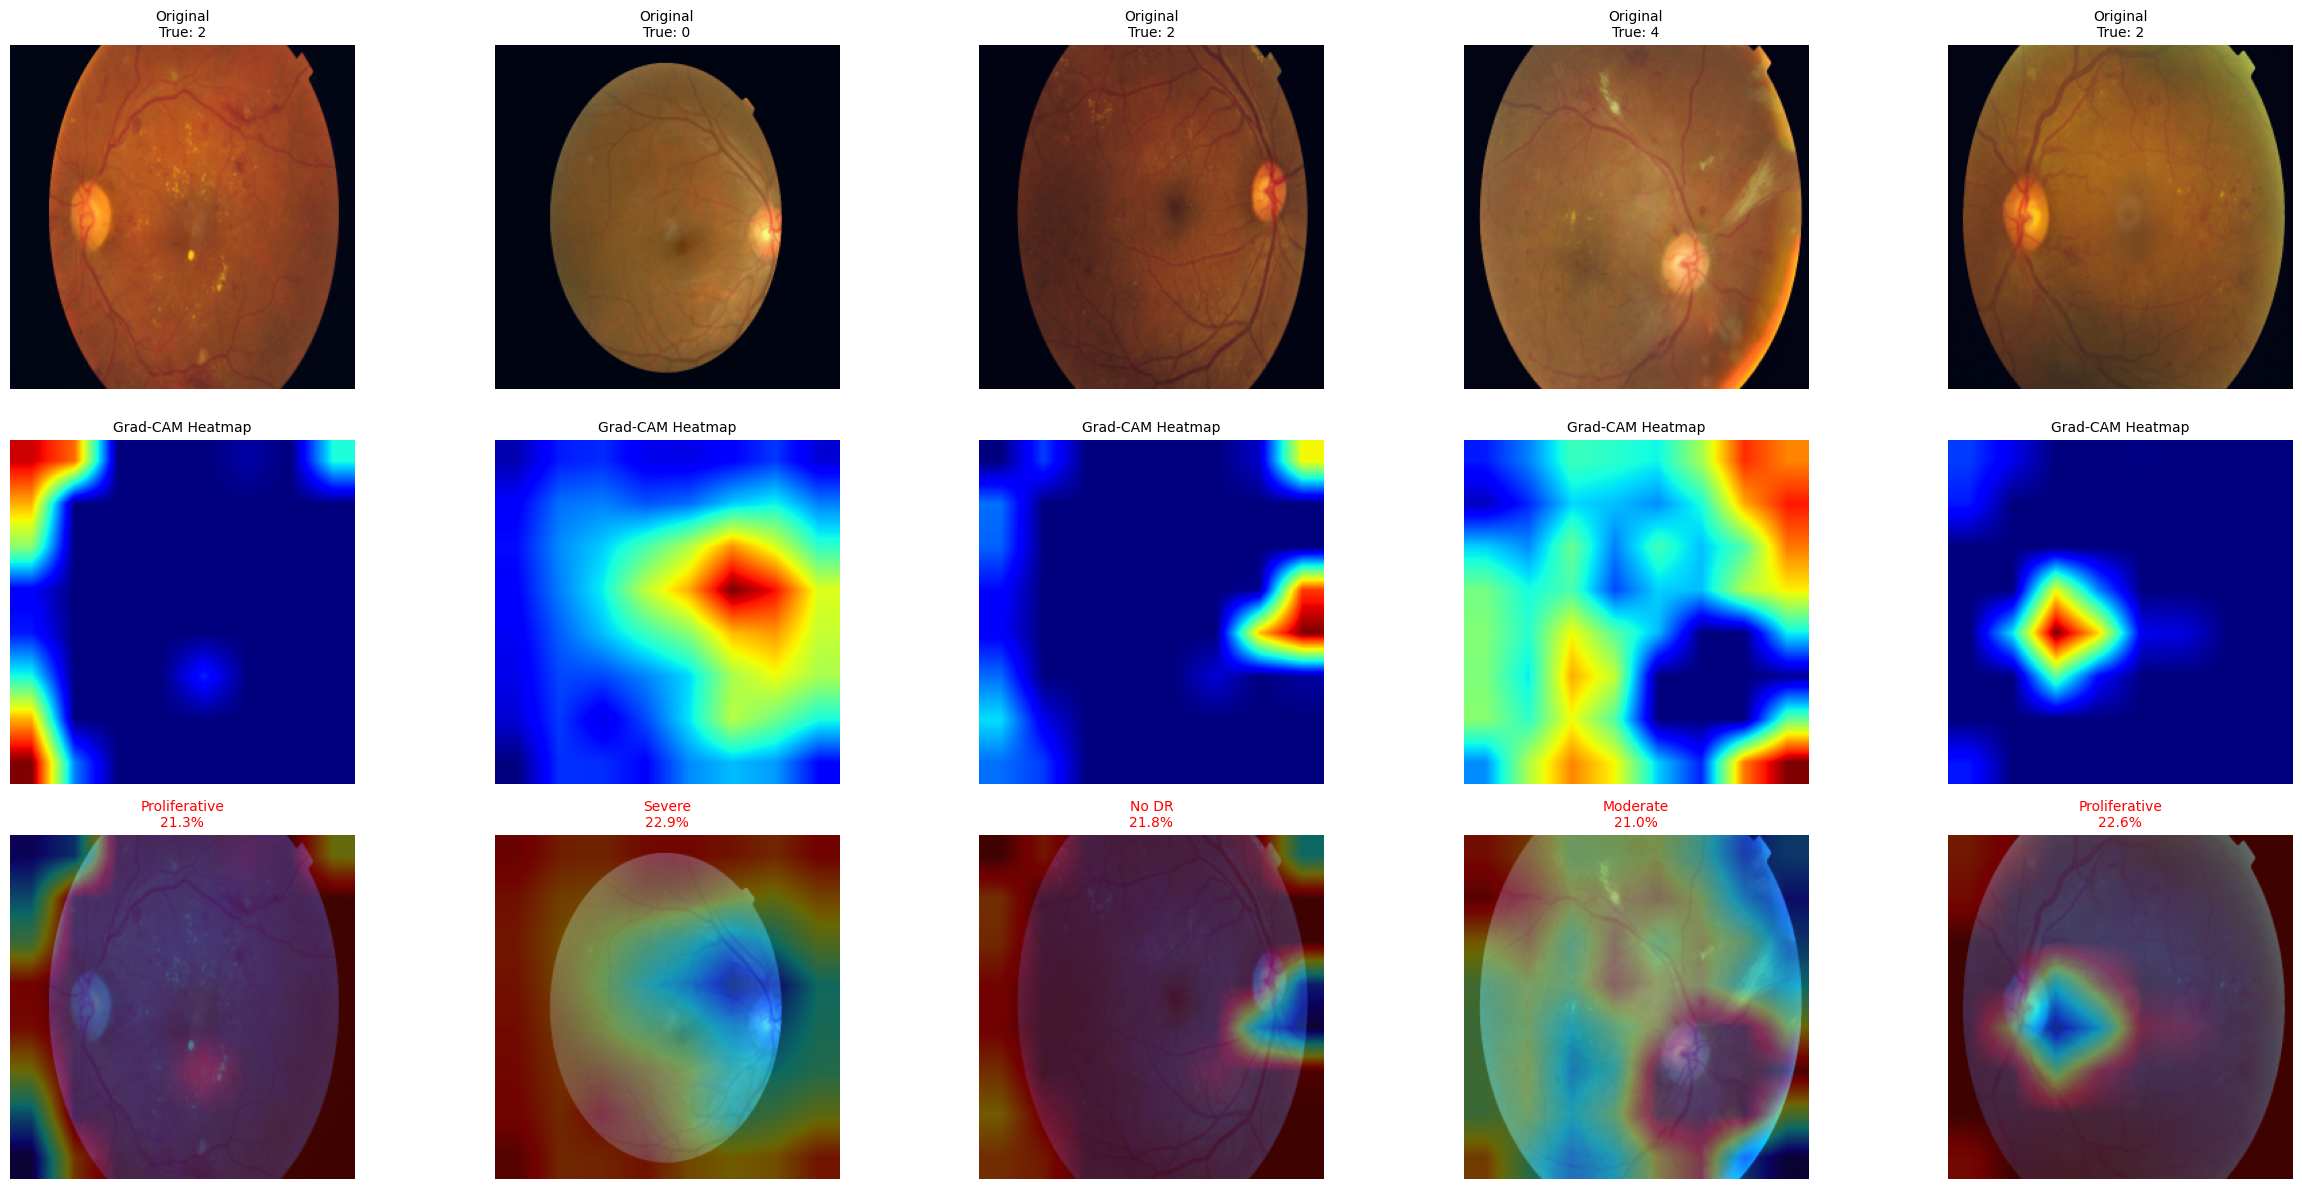

Clinical visualization saved: clinical_reports_sample.png


In [47]:
# Test on 5 random train samples
sample_indices = [100, 500, 1200, 2000, 3000]
fig, axes = plt.subplots(3, 5, figsize=(25, 12))

for i, idx in enumerate(sample_indices):
    sample_img, label = train_dataset[idx]
    overlay, orig_img, heatmap, report, severity, conf = generate_clinical_report(sample_img, model, f"IMG_{idx}", label)
    
    axes[0, i].imshow(orig_img)
    axes[0, i].set_title(f'Original\nTrue: {label}', fontsize=10)
    axes[0, i].axis('off')
    
    axes[1, i].imshow(heatmap, cmap='jet')
    axes[1, i].set_title('Grad-CAM Heatmap', fontsize=10)
    axes[1, i].axis('off')
    
    axes[2, i].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    color = 'green' if conf > 0.9 else 'red'
    axes[2, i].set_title(f'{severity}\n{conf:.1%}', fontsize=10, color=color)
    axes[2, i].axis('off')

plt.tight_layout()
plt.savefig('clinical_reports_sample.png', dpi=300, bbox_inches='tight')
plt.show()
print("Clinical visualization saved: clinical_reports_sample.png")



CLINICAL AI ASSESSMENT REPORT
Patient ID: 0005cfc8afb6
Prediction: Moderate Diabetic Retinopathy
Confidence: 22.6%

Severity Breakdown:
  No DR: 16.5%
  Mild: 20.2%
  Moderate: 22.6%
  Severe: 22.1%
  Proliferative: 18.6%



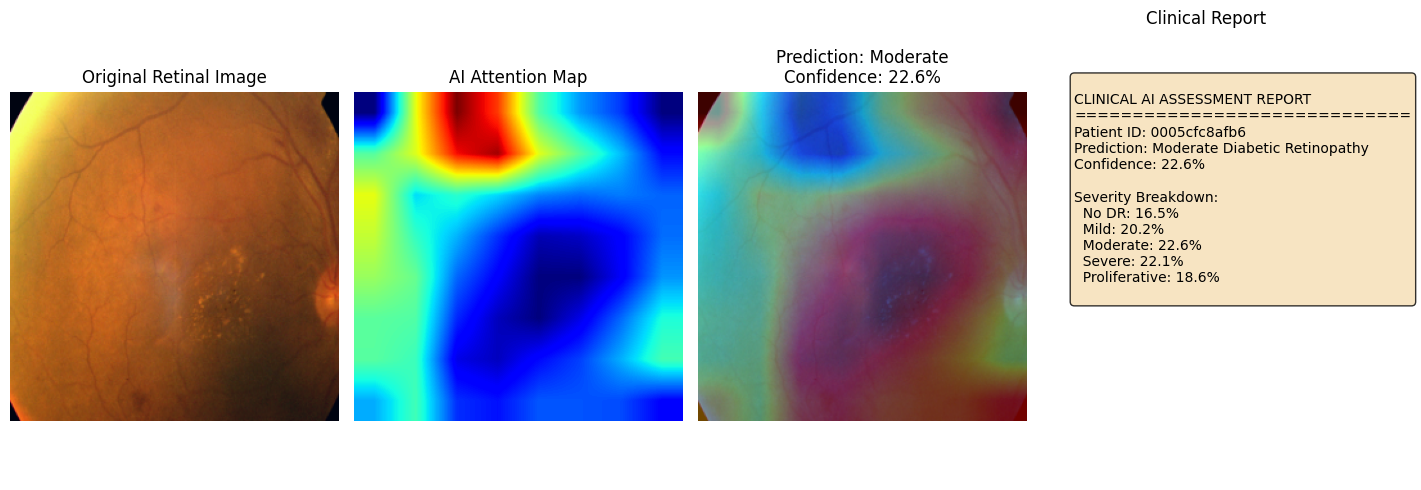

Single patient clinical report saved: single_patient_report.png


In [48]:
test_idx = 0
test_img, test_id = test_dataset[test_idx]

overlay, orig_img, heatmap, report, severity, confidence = generate_clinical_report(
    test_img, model, test_id
)

print(report)
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(orig_img)
plt.title('Original Retinal Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(heatmap, cmap='jet')
plt.title('AI Attention Map')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title(f'Prediction: {severity}\nConfidence: {confidence:.1%}')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.text(0.1, 0.9, report, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
plt.title('Clinical Report')
plt.axis('off')

plt.tight_layout()
plt.savefig('single_patient_report.png', dpi=300, bbox_inches='tight')
plt.show()
print("Single patient clinical report saved: single_patient_report.png")
